<a href="https://colab.research.google.com/github/CarlosMendez1997Sei/WETSAT_v2/blob/main/2_Modelling_WETSAT_Google_Colab/Wetsat_Geoprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

	Google Colaboratory
	PostgreSQL
	GitHub	     
	Wetlands flooding extent and trends using SATellite data and Machine Learning WETSAT
	Code Developed by
	Carlos Mendez
	Sebastian Palomino
	Camilo Sanabria                     

# Install packages and libraries used in WETSAT

In [1]:
###################################### Artificial Intelligence Frameworks #####################################################
# scikit-learn Framework
!pip install scikit-learn
# Tensorflow Framework
!pip install tensorflow
# Keras Framework
!pip install Keras
###################################### Data, Geoprocessing and Graphics libraries #####################################################
!pip install rasterio
!pip install matplotlib
!pip install numpy
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 56.7 MB/s eta 0:00:00


# Import libraries and packages

In [2]:
## AI packages
import tensorflow
import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

## Geoprocessing packages
import rasterio
from rasterio.features import rasterize
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import contextily as ctx
from shapely.geometry import box
import seaborn as sns

# Clone Repository from WETSAT [GitHub](https://github.com/sei-latam/WETSAT_v2)

In [3]:
!git clone https://github.com/sei-latam/WETSAT_v2.git

Cloning into 'WETSAT_v2'...
remote: Enumerating objects: 798, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 798 (delta 76), reused 48 (delta 48), pack-reused 699 (from 1)
Receiving objects: 100% (798/798), 3.12 GiB | 26.18 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Updating files: 100% (318/318), done.


# Import sigma_dB images from [Google Cloud](https://storage.googleapis.com/wetsat_ml/sigma_dB.zip)

In [12]:
'''
# Step 1: Download the ZIP file
url = "https://storage.googleapis.com/wetsat_ml/sigma_dB.zip"
zip_path = "sigma_dB.zip"

response = requests.get(url)
with open(zip_path, "wb") as f:
    f.write(response.content)

# Step 2: Extract the ZIP file
extract_dir = "sigma_dB"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Step 3: List all .tif files
tif_files = [f for f in os.listdir(extract_dir) if f.lower().endswith('.tif')]
print("Extracted .tif files:")
for tif in tif_files:
    print(tif)

'''

'\n# Step 1: Download the ZIP file\nurl = "https://storage.googleapis.com/wetsat_ml/sigma_dB.zip"\nzip_path = "sigma_dB.zip"\n\nresponse = requests.get(url)\nwith open(zip_path, "wb") as f:\n    f.write(response.content)\n\n# Step 2: Extract the ZIP file\nextract_dir = "sigma_dB"\nwith zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n    zip_ref.extractall(extract_dir)\n\n# Step 3: List all .tif files\ntif_files = [f for f in os.listdir(extract_dir) if f.lower().endswith(\'.tif\')]\nprint("Extracted .tif files:")\nfor tif in tif_files:\n    print(tif)\n\n'

# Import Sentinel-1 Raster Images (VH-VV) and create Polarization Ratio (PR) index

In [4]:
vh_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/VH"
vv_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/VV"

output_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/PR_index"

# Create output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# List VH and VV files (assuming matching filenames)
vh_files = sorted([f for f in os.listdir(vh_path) if f.endswith(".tif")])
vv_files = sorted([f for f in os.listdir(vv_path) if f.endswith(".tif")])

# Loop through files and compute PR index
for vh_file, vv_file in zip(vh_files, vv_files):
    with rasterio.open(os.path.join(vh_path, vh_file)) as vh_src, \
         rasterio.open(os.path.join(vv_path, vv_file)) as vv_src:

        vh = vh_src.read(1).astype("float32")
        vv = vv_src.read(1).astype("float32")

        # Avoid division by zero
        vv[vv == 0] = np.nan

        pr_index = vh / vv

        # Save PR index
        profile = vh_src.profile
        profile.update(dtype="float32", count=1)

        pr_filename = f"PR_{vh_file}"
        with rasterio.open(os.path.join(output_path, pr_filename), "w", **profile) as dst:
            dst.write(pr_index, 1)

print("PR index computation complete.")

PR index computation complete.


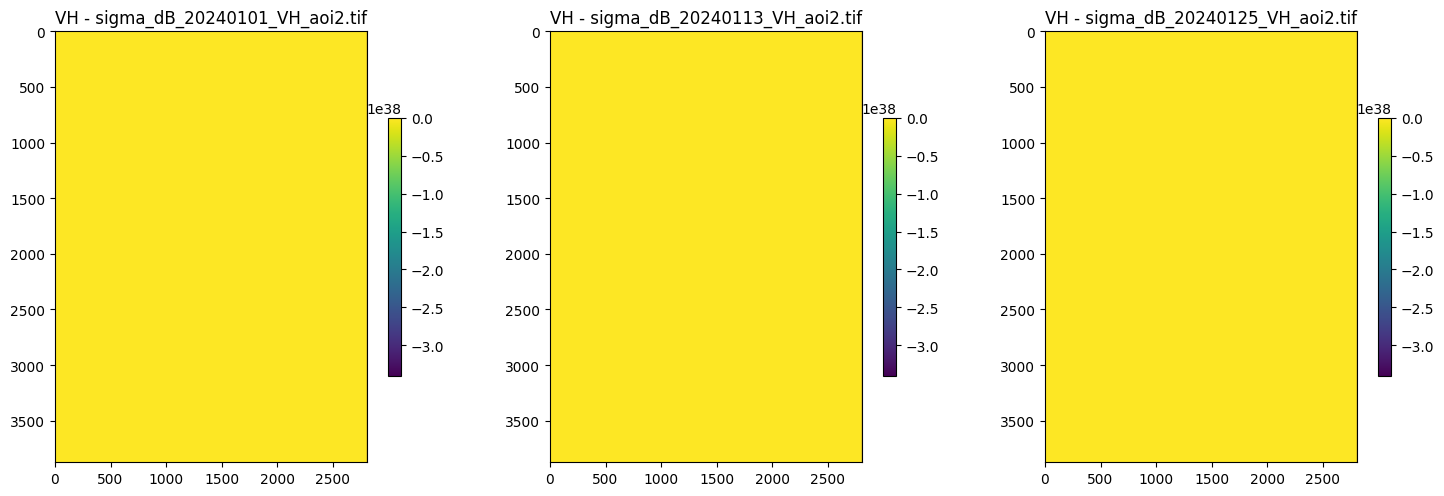

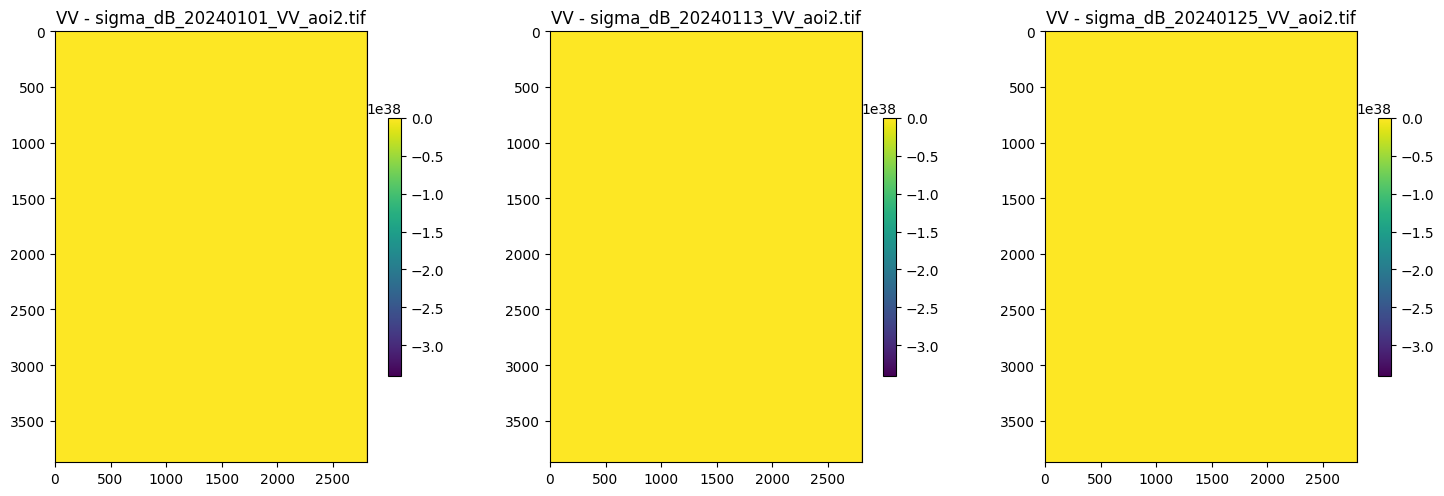

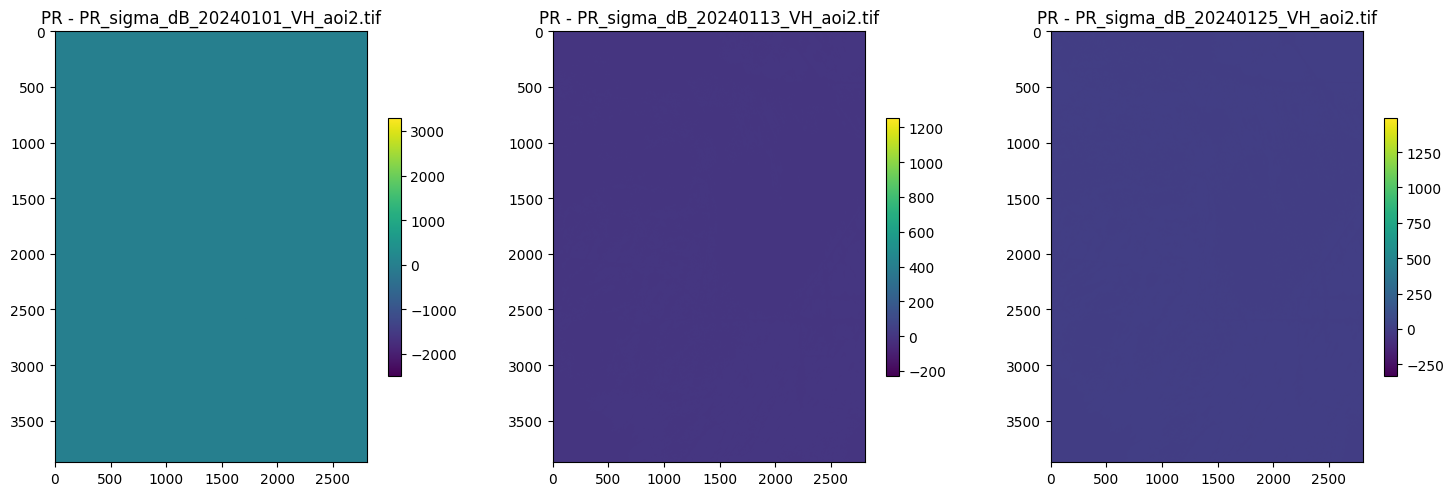

In [5]:
def load_stack(folder):
    files = sorted([f for f in os.listdir(folder) if f.endswith(".tif")])
    stack = []
    for f in files:
        with rasterio.open(os.path.join(folder, f)) as src:
            stack.append(src.read(1))
    return np.stack(stack), files

# Paths
vh_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/VH"
vv_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/VV"
pr_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/PR_index"

# Load stacks
vh_stack, vh_files = load_stack(vh_path)
vv_stack, vv_files = load_stack(vv_path)
pr_stack, pr_files = load_stack(pr_path)

def plot_samples(stack, titles, label):
    fig, axs = plt.subplots(1, len(stack), figsize=(5 * len(stack), 5))
    for i, ax in enumerate(axs):
        im = ax.imshow(stack[i], cmap="viridis")
        ax.set_title(f"{label} - {titles[i]}")
        fig.colorbar(im, ax=ax, shrink=0.6)
    plt.tight_layout()
    plt.show()

# Plot first 3 images from each stack
plot_samples(vh_stack[:3], vh_files[:3], "VH")
plot_samples(vv_stack[:3], vv_files[:3], "VV")
plot_samples(pr_stack[:3], pr_files[:3], "PR")

In [24]:
# Visualize images from sigma_dB_vh

# Path to the folder containing .tif files
tif_files = [f for f in os.listdir(vh_path) if f.lower().endswith('.tif')]

# Display normalized images
for tif_file in tif_files[:29]:  # Show first 3 images
    file_path = os.path.join(vh_path, tif_file)
    with rasterio.open(file_path) as src:
        img = src.read(1).astype(float)
        # Normalize image to 0–1 range
        img_min, img_max = np.percentile(img, [2, 98])  # Robust min/max
        img = np.clip((img - img_min) / (img_max - img_min), 0, 1)

        plt.figure(figsize=(6, 6))
        plt.title(tif_file)
        plt.imshow(img, cmap='gray')
        plt.colorbar()
        plt.axis('off')
        plt.show()

RasterioIOError: /content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/VH/sample_vh.tif: No such file or directory

In [15]:
# Create a function to load images in a folder
def load_images(folder_path): # Create a request 'folder path' as a directory of data
    images = [] # Create a temporal empty array of images
    for file in sorted(os.listdir(folder_path)): # Call the folfer 'path'
        if file.endswith(".tif"): # Search images ending in .tif
            with rasterio.open(os.path.join(folder_path, file)) as src: # Open the images located in folder path
                images.append(src.read(1))
    return np.array(images) # Return array of images

# Call function and load images
vh_images = load_images(vh_path)
vv_images = load_images(vv_path)

print(f"System recognized {vh_images.shape[0]} images VH polarization with size {vh_images.shape[1:]} each one.")
print(f"System recognized {vv_images.shape[0]} images VV polarization with size {vv_images.shape[1:]} each one.")
assert vh_images.shape == vv_images.shape, "The dimensions and size of VH-VV polarizations are equal"

# Combine the VH-VV polarization with the same size and dimensions
master_data = np.stack([vh_images, vv_images], axis=-1)  # (n_images)

print(f"System combine the VH-VV polarization wit the size {master_data.shape}")

System recognized 24 images VH polarization with size (3875, 2804) each one.
System recognized 24 images VV polarization with size (3875, 2804) each one.
System combine the VH-VV polarization wit the size (24, 3875, 2804, 2)


# Import points (.shp) with labels and marks

In [18]:
# Open shapefile folder
shapefile_path = "/content/WETSAT_v2/0_Original_Files/aoi2/points_AOI2_BDE.shp"

# Import geopandas and read .shp
gdf = gpd.read_file(shapefile_path)
print(f"The attributes of the .shp are:")
print(gdf)

# Get coordinates of .shp
x_coords = gdf.geometry.x
y_coords = gdf.geometry.y

coords = [(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry]
print(f"The coordinates of the .shp are:")
print(coords)

# Get values of the column "gridcode"
labels = gdf["1_01_2024_"].values

# Print values
print(f"The marks and labels found in .shp are:")
print(labels)

The attributes of the .shp are:
    Station 1_01_2024_ 1_13_2024_ 1_25_2024_ 2_06_2024_ 2_18_2024_ 3_01_2024_  \
0      3A11        e11        e11        e11        e11        e21        e21   
1      3A12        e21        e21        e21        e21        e21        e21   
2    3AN1W1        e21        e21        e21        e21        e21        e21   
3       3AS        e22        e22        e22        e22        e22        e22   
4    3AS3W1        e21        e21        e21        e21        e21        e21   
5      3ASW        e21        e21        e21        e21        e21        e21   
6     BCA10        e23        e23        e23        e23        e13        e13   
7     BCA12        e23        e23        e23        e23        e23        e23   
8     BCA13        e23        e23        e23        e23        e23        e23   
9     BCA18        e21        e21        e21        e21        e21        e21   
10    BCA20        e21        e21        e21        e21        e21        e21

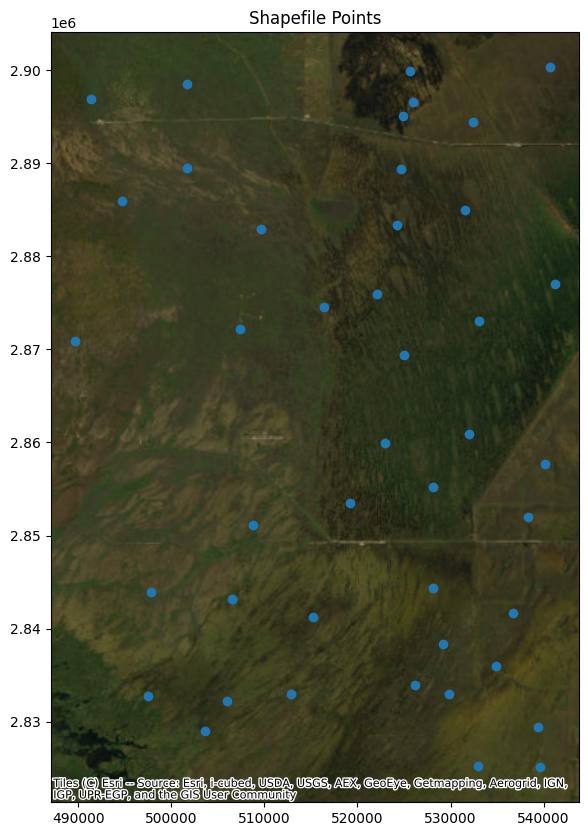

In [19]:
#providers = ctx.providers
#providers

# Plot the .shp
ax = gdf.plot(figsize=(10, 10))
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery)
plt.title('Shapefile Points')
plt.show()

# Create marks/labels and rasterize (convert vector to raster)

In [21]:
# Verify and compare if the .shp have the same .src with vh_path/vv_path
with rasterio.open(os.path.join(vh_path, os.listdir(vh_path)[0])) as src:
    transform = src.transform
    raster_crs = src.crs

print("The Coordinate Reference System (CRS) is :", raster_crs)

gdf = gdf.to_crs(raster_crs)


print("Bounds image:", src.bounds)
print("Bounds shapefile:", gdf.total_bounds)

raster_bounds = box(*src.bounds)
gdf_filtered = gdf[gdf.geometry.within(raster_bounds)]
print(f"Points inside raster: {len(gdf_filtered)} of {len(gdf)}")

The Coordinate Reference System (CRS) is : EPSG:32617
Bounds image: BoundingBox(left=488300.0, bottom=2823700.0, right=544380.0, top=2901200.0)
Bounds shapefile: [ 489599.51383088 2825091.04763268  541222.74691443 2900327.16197831]
Points inside raster: 43 of 43


# Prepare training data

In [ ]:
# Create x and y train data
X_train = []
y_train = []

# Call function to iterate or looping in each image from master_data dataset
for i in range(master_data.shape[0]): #Calculate the size of master_data
    img = master_data[i]  # Receive height and weight
    img_flat = img.reshape(-1, 2) # Transform the image into an array, when -1 meaning automatic fields and 2 set number of rows
    labels_flat = raster_labels.flatten()
    mask = labels_flat > 0 #Validate only labels > 0

    #Filter or mask data in x/y training data
    X_train.append(img_flat[mask])
    y_train.append(labels_flat[mask])

# concatenate data
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

print(f"Total samples: {X_train.shape[0]}")

X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.3)

Total samples: 203


# Random Forest (RF) Model

## Configure best Hyperparameters

In [ ]:
# Define the hyperparameters and grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the RF model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_tr, y_tr)
print("Accuracy Random Forest Model:", rf.score(X_te, y_te))

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           verbose=2,
                           n_jobs=-1)  # Use all available cores

# Fit to training data
grid_search.fit(X_tr, y_tr)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Accuracy Random Forest Model: 0.7704918032786885
Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
243 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
124 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/util

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.7256205673758865


## Visualize precision, score and confusion matriz

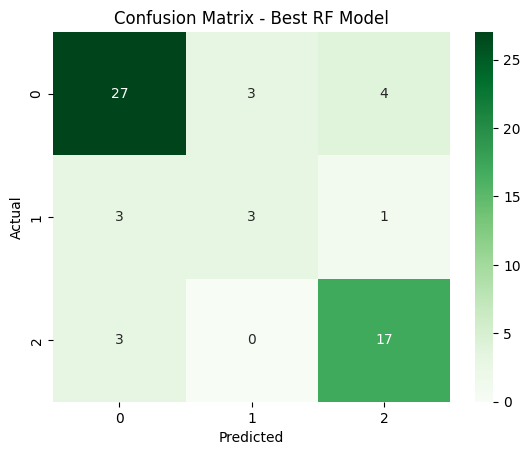

              precision    recall  f1-score   support

          22       0.82      0.79      0.81        34
          24       0.50      0.43      0.46         7
          26       0.77      0.85      0.81        20

    accuracy                           0.77        61
   macro avg       0.70      0.69      0.69        61
weighted avg       0.77      0.77      0.77        61



In [ ]:
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_te)

# Confusion Matrix
cm_best = confusion_matrix(y_te, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Best RF Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_te, y_pred_best))

## Plot and visualize first image

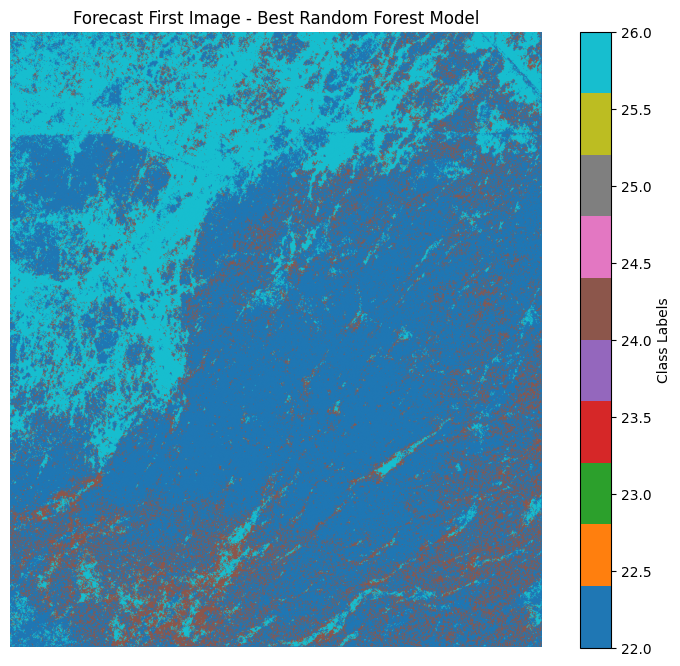

In [ ]:
img = master_data[0] # Select an Image S1 (combined VH/VV)

height, width = img.shape[:2] # select first image

# Create a new organization of data to forecast pixels
img_flat = img.reshape(-1, 2)

# Predict with best model
predicted_labels_best = best_rf.predict(img_flat)
predicted_raster_best = predicted_labels_best.reshape(height, width)

# Visualize results
plt.figure(figsize=(10, 8))
plt.imshow(predicted_raster_best, cmap='tab10')
plt.title("Forecast First Image - Best Random Forest Model")
plt.colorbar(label='Class Labels')
plt.axis('off')
plt.show()

## Visualize forecast RF in each image

In [ ]:
classified_stack = []

for i in range(master_data.shape[0]):
    img = master_data[i]  # (height, width, 2)
    height, width = img.shape[:2]
    img_flat = img.reshape(-1, 2)

    predicted_labels = best_rf.predict(img_flat)
    predicted_raster = predicted_labels.reshape(height, width)

    classified_stack.append(predicted_raster)

In [ ]:
# Run the following code to visualize all images

'''
for i, classified_img in enumerate(classified_stack):
    plt.figure(figsize=(8, 6))
    plt.imshow(classified_img, cmap='tab10')
    plt.title(f"Classified Map - Scene {i+1}")
    plt.axis('off')
    plt.colorbar(label='Class Labels')
    plt.show()
'''

'\nfor i, classified_img in enumerate(classified_stack):\n    plt.figure(figsize=(8, 6))\n    plt.imshow(classified_img, cmap=\'tab10\')\n    plt.title(f"Classified Map - Scene {i+1}")\n    plt.axis(\'off\')\n    plt.colorbar(label=\'Class Labels\')\n    plt.show()\n'

# Support Vector Machine (SVM)

## Configure Hyperparameters

In [ ]:
# Define hyperparameters and grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # Only used for 'poly' kernel
}

# Initialize SVM model
svm = SVC()
svm.fit(X_tr, y_tr)
print("Accuracy Support Vector Machine (SVM) Model:", svm.score(X_tr, y_tr))

# Set up GridSearchCV
grid_search_svm = GridSearchCV(estimator=svm,
                                param_grid=param_grid,
                                cv=3,
                                verbose=2,
                                n_jobs=-1)

# Fit to training data
grid_search_svm.fit(X_tr, y_tr)

# Best parameters and score
print("Best Parameters (SVM):", grid_search_svm.best_params_)
print("Best Cross-Validation Score (SVM):", grid_search_svm.best_score_)

best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_te)

Accuracy Support Vector Machine (SVM) Model: 0.7183098591549296
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters (SVM): {'C': 0.1, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}
Best Cross-Validation Score (SVM): 0.7399527186761229


## Visualize precision, score and confusion matriz

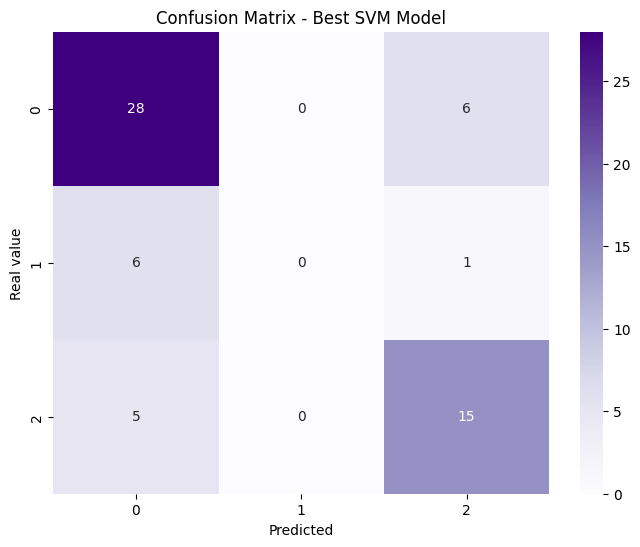

Classification Report - Best SVM Model
              precision    recall  f1-score   support

          22       0.72      0.82      0.77        34
          24       0.00      0.00      0.00         7
          26       0.68      0.75      0.71        20

    accuracy                           0.70        61
   macro avg       0.47      0.52      0.49        61
weighted avg       0.62      0.70      0.66        61



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Calculate confusion matrix

# Visualize data
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_te, y_pred_svm), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Best SVM Model")
plt.xlabel("Predicted")
plt.ylabel("Real value")
plt.show()

# Print results
print("Classification Report - Best SVM Model")
print(classification_report(y_te, y_pred_svm))

## Plot and visualize first image

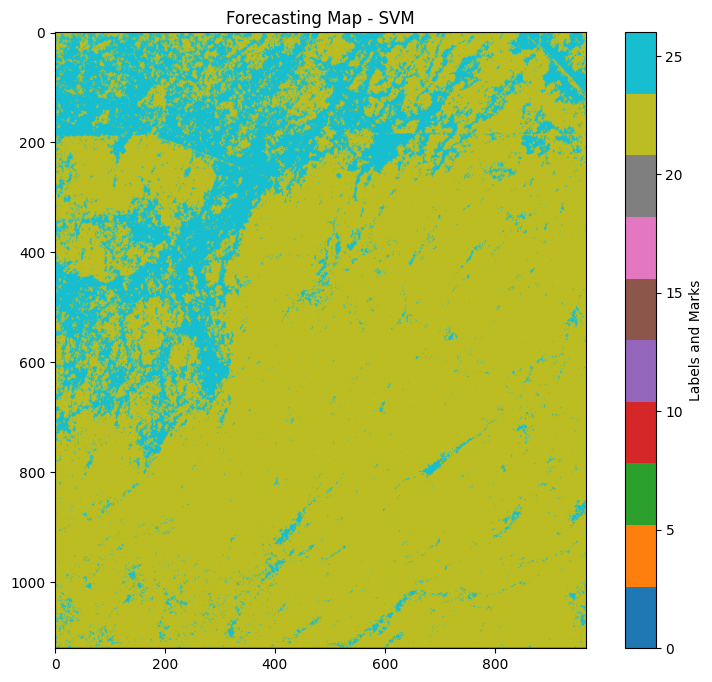

In [ ]:
img = master_data[0] # Select an Image S1 (combined VH/VV)

height, width = img.shape[:2] # select first image

# Create a new organization of data to forecast pixels
img_flat = img.reshape(-1, 2)

# Delete NaN or null values if there are
mask_valid = ~np.isnan(img_flat).any(axis=1)
img_flat_clean = img_flat[mask_valid]

# Forecasting labels only for valid pixels
predicted_labels_svm = svm.predict(img_flat_clean)

# Create a new empty raster and fill with valid pixels
predicted_raster_svm = np.zeros(img_flat.shape[0], dtype=predicted_labels_svm.dtype)
predicted_raster_svm[mask_valid] = predicted_labels_svm
predicted_raster_svm = predicted_raster_svm.reshape(height, width)

plt.figure(figsize=(10, 8))
plt.imshow(predicted_raster_svm, cmap='tab10')
plt.title("Forecasting Map - SVM")
plt.axis('on')
plt.colorbar(label='Labels and Marks')
plt.show()

## Visualize forecast SVM in each image

In [ ]:
svm_classified_stack = []

for i in range(master_data.shape[0]):
    img = master_data[i]  # (height, width, 2)
    height, width = img.shape[:2]
    img_flat = img.reshape(-1, 2)

    # Handle NaN values
    mask_valid = ~np.isnan(img_flat).any(axis=1)
    img_flat_clean = img_flat[mask_valid]

    # Predict only valid pixels
    predicted_labels = best_svm.predict(img_flat_clean)

    # Reconstruct full raster
    predicted_raster = np.zeros(img_flat.shape[0], dtype=predicted_labels.dtype)
    predicted_raster[mask_valid] = predicted_labels
    predicted_raster = predicted_raster.reshape(height, width)

    svm_classified_stack.append(predicted_raster)

In [ ]:
# Run the following code to visualize all images

'''
for i, classified_img in enumerate(svm_classified_stack):
    plt.figure(figsize=(8, 6))
    plt.imshow(classified_img, cmap='tab10')
    plt.title(f"SVM Classified Map - Scene {i+1}")
    plt.axis('off')
    plt.colorbar(label='Class Labels')
    plt.show()
'''

'\nfor i, classified_img in enumerate(svm_classified_stack):\n    plt.figure(figsize=(8, 6))\n    plt.imshow(classified_img, cmap=\'tab10\')\n    plt.title(f"SVM Classified Map - Scene {i+1}")\n    plt.axis(\'off\')\n    plt.colorbar(label=\'Class Labels\')\n    plt.show()\n'